In [ ]:
# Read readme.md from github
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/Challenge_1/"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Challenge_1


## Import Python packages

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["MPLCONFIGDIR"] = os.getcwd() + "/configs/"

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

import numpy as np

np.random.seed(seed)

import logging

import random

random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
import seaborn as sns

2.14.0


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score

In [ ]:
IMG_SIZE = 224

## Import dataset

* Dataset from which troll and outlayey are removed `Dataset_cleaning.ipynb`

In [ ]:
dataset = np.load('new_dataset.npz', allow_pickle=True)
images = dataset['data']
labels = dataset['labels']

In [ ]:
# Extract classes separately
healthy_labels = np.where(labels == "healthy")[0]
unhealthy_labels = np.where(labels == "unhealthy")[0]

healthy_images = images[healthy_labels]
unhealthy_images = images[unhealthy_labels]

### Split dataset

In [ ]:
X = np.concatenate([healthy_images, unhealthy_images], axis=0)
y = np.concatenate([np.zeros(len(healthy_images)), np.ones(len(unhealthy_images))], axis=0)

* For final submision we transfered all data from **test set** to training and validation set
* To boost performance - final test will be on codalab test set

In [ ]:
# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, random_state=seed, test_size=0.10, stratify=y
)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    random_state=seed,
    test_size=0.20,
    stratify=y,
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
# print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3625, 96, 96, 3), y_train shape: (3625,)
X_val shape: (907, 96, 96, 3), y_val shape: (907,)


### Preproces input - EfficientNet
* utuility function for preprocessing data for EfficetNet

In [ ]:
def proc_input(X_input):
    X_input = tfkl.Resizing(IMG_SIZE, IMG_SIZE)(X_input)
    X_input = tf.cast(X_input, tf.float32)
    X_input = tf.keras.applications.efficientnet.preprocess_input(X_input)
    return X_input

X_train = proc_input(X_train)
X_val = proc_input(X_val)
# X_test = proc_input(X_test)  ## See last function


### Data balancing

We tested two approaches for data balancing:
* weight balancing
* data augmenation of minority class

Previously we would calculate class weights for each class:

  ```
  # Calculate class weights
  num_samples = len(y_train)
  num_positive_samples = np.sum(y_train == 1)
  num_negative_samples = np.sum(y_train == 0)

  weight_for_0 = num_samples / (2 * num_negative_samples)
  weight_for_1 = num_samples / (2 * num_positive_samples)

  class_weight = {0: weight_for_0, 1: weight_for_1}
  ```
* And then we would assignt `class_weight=class_weight` inside `model.fit()` function

On our tests weight balancing had better results but The score on Codalab was worse. Probably because the balancing was different.

Therfore we choose to augment the unhealthy images.

We wrote function to balance dataset based on dictionary input which consist augemntation function and percentage of how much data should be augmented with this function
```
augmentMethodDict = {
    flip: 0.3,
    translation: 0.3,
    rotation: 0.4,
}
```
* For example 30% of data should be augmented by predefined flip augmentation function

In [ ]:
def populate_dataset(originalDataset: np.ndarray, augmentMethodDict: dict, wantedSize:int) -> np.ndarray:
  # Calculate the sum of the values in the dictionary,
  total_prob = np.sum(list(augmentMethodDict.values()))

  # Check if the sum is not equal to 1 (with some tolerance for floating-point precision)
  if not np.isclose(total_prob, 1.0):
      # Normalize the values in the dictionary to make the sum equal to 1
      augmentMethodDict = {key: value / total_prob for key, value in augmentMethodDict.items()}

  diff = wantedSize - len(originalDataset)

  for AugFunct, percentage in augmentMethodDict.items():
    number_of_images = int(percentage * diff)
    random_indices = np.random.choice(len(originalDataset), number_of_images, replace=False)
    random_elements = originalDataset[random_indices]
    augmented_images = AugFunct(random_elements)
    originalDataset = np.concatenate((originalDataset, augmented_images))

  if len(originalDataset) < wantedSize:
    diff = wantedSize - len(originalDataset)
    random_indices = np.random.choice(len(originalDataset), diff, replace=False)
    random_elements = originalDataset[random_indices]
    originalDataset = np.concatenate((originalDataset, random_elements))

  if len(originalDataset) > wantedSize:
    originalDataset = originalDataset[:wantedSize]

  return originalDataset

In [ ]:
flip = tf.keras.Sequential([tfkl.RandomFlip("horizontal")])

translation = tf.keras.Sequential([tfkl.RandomTranslation(0.2, 0.2)])

rotation = tf.keras.Sequential([tfkl.RandomRotation(0.2)])

augmentMethodDict = {
    flip: 0.3,
    translation: 0.3,
    rotation: 0.4,
}

The unhealthy images will be augmented to balance the dataset

In [ ]:
X_train = X_train.numpy()

# Seperate the healthy and unhealthy images
healthy_images = X_train[np.where(y_train == 0)[0]]
unhealthy_images = X_train[np.where(y_train == 1)[0]]

#healthy_images = tf.convert_to_tensor(populate_dataset(healthy_images, augmentMethodDict, 1000))
unhealthy_images = tf.convert_to_tensor(populate_dataset(unhealthy_images, augmentMethodDict, len(healthy_images)))
print(healthy_images.shape)
print(unhealthy_images.shape)

# Concatenate the healthy and unhealthy images
X_train = tf.concat([healthy_images, unhealthy_images], axis=0)

# Create the labels healthy and unhealthy
healthy_labels = tf.convert_to_tensor([0] * len(healthy_images))
unhealthy_labels = tf.convert_to_tensor([1] * len(unhealthy_images))
y_train = tf.concat([healthy_labels, unhealthy_labels], axis=0)

# Shuffle the data
# Shuffle the data wich is an np.array
X_train, y_train = tf.random.shuffle(X_train, seed=seed), tf.random.shuffle(y_train, seed=seed)

(2320, 224, 224, 3)
(2320, 224, 224, 3)


In [ ]:
# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (4640, 224, 224, 3), y_train shape: (4640,)
X_val shape: (907, 224, 224, 3), y_val shape: (907,)


### Training input parameters

In [ ]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = 1
batch_size = 80
epochs = 40

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

Input Shape: (224, 224, 3), Output Shape: 1, Batch Size: 80, Epochs: 40


### Callbacks

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=8,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.000001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=15)

calbacks = [reduce_lr, early_stopping]

### Data augmentations

In [ ]:
img_augmentation = tfk.Sequential(
    [
        tfk.layers.RandomRotation(factor=0.15),
        tfk.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tfk.layers.RandomFlip(),
        tfk.layers.RandomContrast(factor=0.1),
        tfk.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    ],
    name="img_augmentation",
)

## Model 1

### Model 1 - train freezed CNN
* We used `learning_rate = 0.001` which is a bit high but we decided for it because we are only tarining dense layer
* We also decided to use base EfficientNetB0 model which was trained on image sizes 224x224

* For Upper Layer we decided to use:
```
GlobalAveragePooling2D
BatchNormalization
Dropout - 0.4
Dense(10) - relu, HeUniform
BatchNormalization
Dense - sigmoid (output)
```

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

def build_model(num_classes):
    inputs = tfk.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tfk.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tfk.layers.BatchNormalization()(x)

    x = tfk.layers.Dropout(0.3, name="top1_dropout")(x)
    x = tfk.layers.Dense(10, activation="relu")(x)
    x = tfk.layers.BatchNormalization()(x)

    outputs = tfk.layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)

    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = ["accuracy"]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [ ]:
model_model1 = build_model(num_classes=1)

epochs = 60  # @param {type: "slider", min:8, max:80}
model1 = model_model1.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=calbacks,
    verbose=1,
).history

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/60
58/58 [==============================] - 38s 276ms/step - loss: 0.6001 - accuracy: 0.6664 - val_loss: 0.5823 - val_accuracy: 0.7398 - lr: 0.0010
Epoch 2/60
58/58 [==============================] - 13s 223ms/step - loss: 0.4998 - accuracy: 0.7603 - val_loss: 0.4861 - val_accuracy: 0.8026 - lr: 0.0010
Epoch 3/60
58/58 [==============================] - 12s 214ms/step - loss: 0.4619 - accuracy: 0.7800 - val_loss: 0.4312 - val_accuracy: 0.8302 - lr: 0.0010
Epoch 4/60
58/58 [==============================] - 12s 215ms/step - loss: 0.4506 - accuracy: 0.7858 - val_loss: 0.4090 - val_accuracy: 0.8280 - lr: 0.0010
Epoch 5/60
58/58 [==============================] - 14s 234ms/step - loss: 0.4380 - accuracy: 0.7916 - val_loss: 0.3851 - val_accuracy: 0.8401 - lr: 0.0010
Epoch 6/60
58/58 [==============================] - 13s 220ms/step - loss: 0.4214 - accuracy: 0.8017 - val_loss: 0.3676 - val_accuracy: 0.8434 - lr: 0.0010

### Model 1 - unfreeze CNN
* `learning rate` and `weight_decay` parameters are lowered while we fine tune weights from top `30` layers of EfficientNetB0 layers

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 30 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-30:]:
        if not isinstance(layer, tfk.layers.BatchNormalization):
            layer.trainable = True

    learning_rate = 1e-4
    # Create AdamW optimizer
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
from keras.models import clone_model
model_model1_1 = clone_model(model_model1)
model_model1_1.set_weights(model_model1.get_weights())

unfreeze_model(model_model1_1)

epochs = 60  # @param {type: "slider", min:8, max:80}
model1_1 = model_model1_1.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=calbacks,
    verbose=1,
).history

Epoch 1/60
58/58 [==============================] - 28s 255ms/step - loss: 0.0000e+00 - accuracy: 0.8168 - val_loss: 0.0000e+00 - val_accuracy: 0.8423 - lr: 1.0000e-04
Epoch 2/60
58/58 [==============================] - 13s 228ms/step - loss: 0.0000e+00 - accuracy: 0.8136 - val_loss: 0.0000e+00 - val_accuracy: 0.8412 - lr: 1.0000e-04
Epoch 3/60
58/58 [==============================] - 14s 244ms/step - loss: 0.0000e+00 - accuracy: 0.8155 - val_loss: 0.0000e+00 - val_accuracy: 0.8567 - lr: 1.0000e-04
Epoch 4/60
58/58 [==============================] - 13s 225ms/step - loss: 0.0000e+00 - accuracy: 0.8228 - val_loss: 0.0000e+00 - val_accuracy: 0.8611 - lr: 1.0000e-04
Epoch 5/60
58/58 [==============================] - 14s 234ms/step - loss: 0.0000e+00 - accuracy: 0.8375 - val_loss: 0.0000e+00 - val_accuracy: 0.8644 - lr: 1.0000e-04
Epoch 6/60
58/58 [==============================] - 13s 223ms/step - loss: 0.0000e+00 - accuracy: 0.8440 - val_loss: 0.0000e+00 - val_accuracy: 0.8456 - lr: 1.0

In [ ]:
model_model1_1.save("model_model1_1")

## Model 2

### Model 2 - unfreeze CNN

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 35 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-35:]:
        if not isinstance(layer, tfk.layers.BatchNormalization):
            layer.trainable = True

    learning_rate = 1e-4
    # Create AdamW optimizer
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
model_model2_1 = clone_model(model_model1)
model_model2_1.set_weights(model_model1.get_weights())

unfreeze_model(model_model2_1)

epochs = 40  # @param {type: "slider", min:8, max:50}
model2_1 = model_model2_1.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=calbacks,
    verbose=1,
).history


Epoch 1/40
58/58 [==============================] - 29s 260ms/step - loss: 0.0000e+00 - accuracy: 0.8263 - val_loss: 0.0000e+00 - val_accuracy: 0.8490 - lr: 1.0000e-04
Epoch 2/40
58/58 [==============================] - 14s 244ms/step - loss: 0.0000e+00 - accuracy: 0.8127 - val_loss: 0.0000e+00 - val_accuracy: 0.8556 - lr: 1.0000e-04
Epoch 3/40
58/58 [==============================] - 14s 243ms/step - loss: 0.0000e+00 - accuracy: 0.8267 - val_loss: 0.0000e+00 - val_accuracy: 0.8545 - lr: 1.0000e-04
Epoch 4/40
58/58 [==============================] - 13s 228ms/step - loss: 0.0000e+00 - accuracy: 0.8231 - val_loss: 0.0000e+00 - val_accuracy: 0.8523 - lr: 1.0000e-04
Epoch 5/40
58/58 [==============================] - 13s 225ms/step - loss: 0.0000e+00 - accuracy: 0.8379 - val_loss: 0.0000e+00 - val_accuracy: 0.8655 - lr: 1.0000e-04
Epoch 6/40
58/58 [==============================] - 14s 241ms/step - loss: 0.0000e+00 - accuracy: 0.8433 - val_loss: 0.0000e+00 - val_accuracy: 0.8434 - lr: 1.0

In [ ]:
model_model2_1.save("model_model2_1")

## Model performance

### Accuracy, loss graph

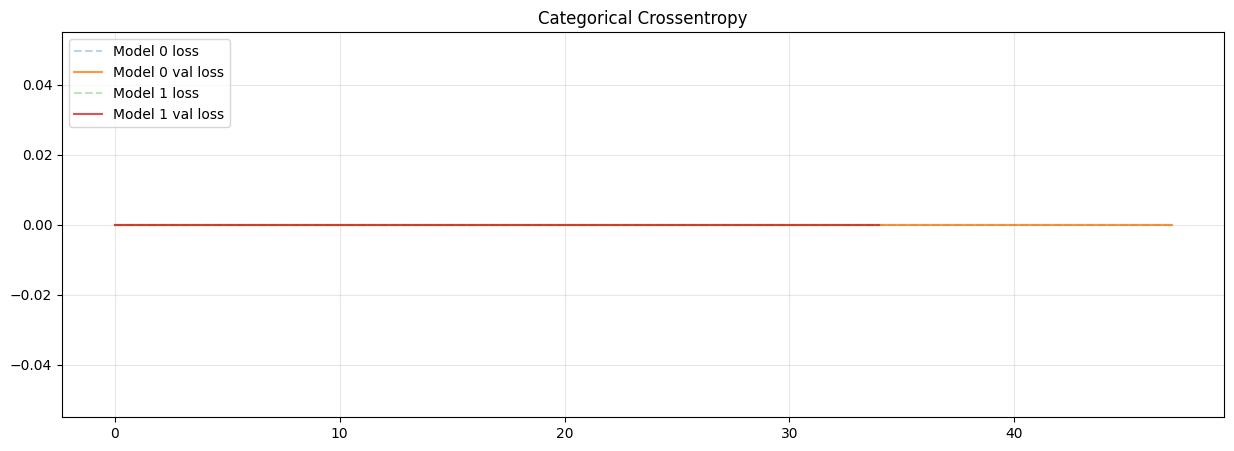

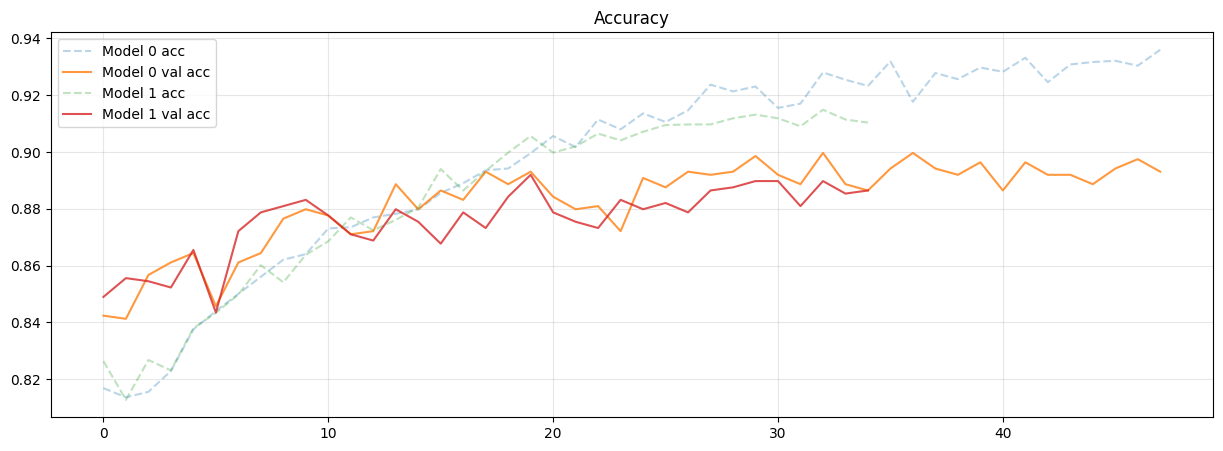

In [ ]:
modelsToPlot = [model1_1, model2_1]

plt.figure(figsize=(15, 5))

for i, model in enumerate(modelsToPlot):
    plt.plot(model["loss"], alpha=0.3, label=f"Model {i} loss", linestyle="--")
    plt.plot(model["val_loss"], label=f"Model {i} val loss", alpha=0.8)

plt.legend(loc="upper left")
plt.title("Categorical Crossentropy")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(15, 5))

for i, model in enumerate(modelsToPlot):
    plt.plot(model["accuracy"], alpha=0.3, label=f"Model {i} acc", linestyle="--")
    plt.plot(model["val_accuracy"], label=f"Model {i} val acc", alpha=0.8)

plt.legend(loc="upper left")
plt.title("Accuracy")
plt.grid(alpha=0.3)
plt.show()


### ROC/AUC curve

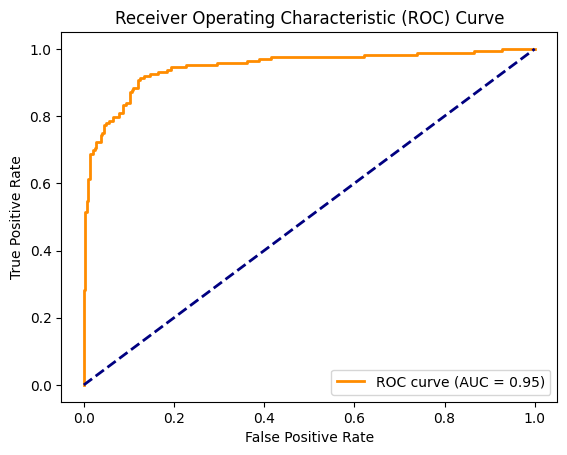

In [ ]:
def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

predictions = model_model1_1.predict(proc_input(X_test), verbose=0)
#predictions_proba = model_model1_1.predict_proba(proc_input(X_test))[:,1]
#predictions = (predictions > 0.5).astype(int)
plot_roc_curve(y_test, predictions)

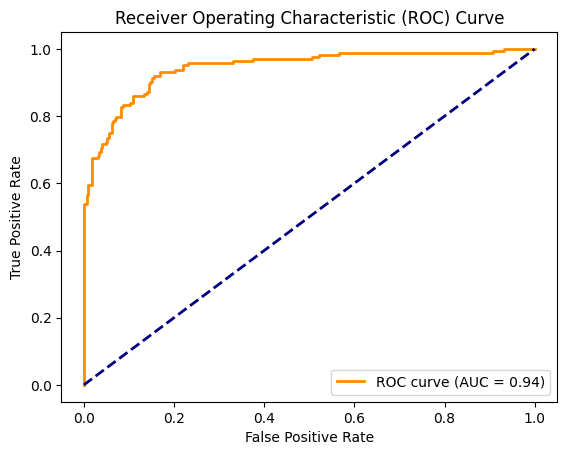

In [ ]:
def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

predictions = model_model2_1.predict(proc_input(X_test), verbose=0)
#predictions = (predictions > 0.5).astype(int)
plot_roc_curve(y_test, predictions)

### Precision-recall curve

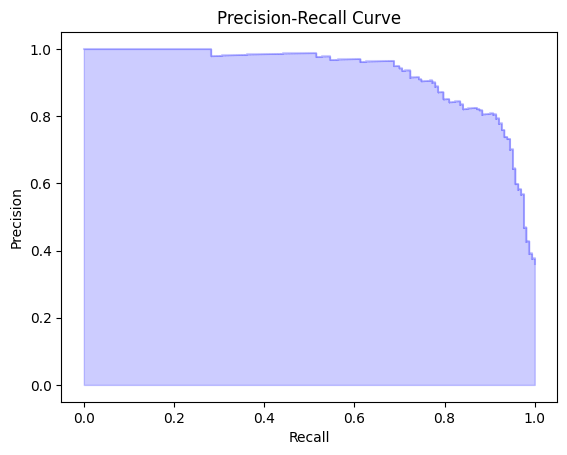

In [ ]:
def plot_precision_recall_curve(y_true, y_probs):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)

    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

predictions = model_model1_1.predict(proc_input(X_test), verbose=0)
#predictions = (predictions > 0.5).astype(int)
plot_precision_recall_curve(y_test, predictions)

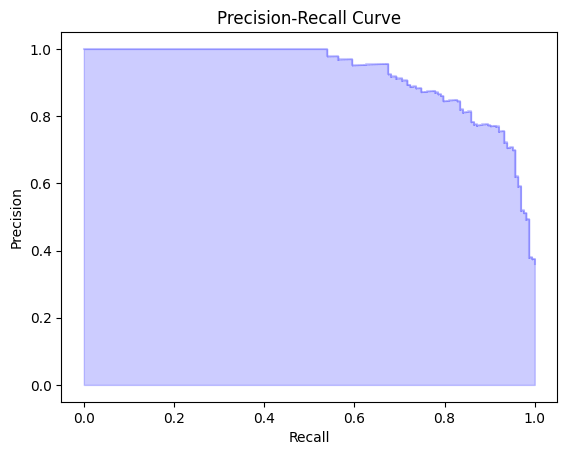

In [ ]:
def plot_precision_recall_curve(y_true, y_probs):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)

    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

predictions = model_model2_1.predict(proc_input(X_test), verbose=0)
#predictions = (predictions > 0.5).astype(int)
plot_precision_recall_curve(y_test, predictions)

### Classification metrics

In [ ]:
predictions = model_model1_1.predict(proc_input(X_test), verbose=0)
predictions = (predictions > 0.5).astype(int)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.8744
Precision: 0.9492
Recall: 0.6871
F1: 0.7972


In [ ]:
predictions = model_model2_1.predict(proc_input(X_test), verbose=0)
predictions = (predictions > 0.5).astype(int)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.8678
Precision: 0.8931
Recall: 0.7178
F1: 0.7959


### Confusion matrix

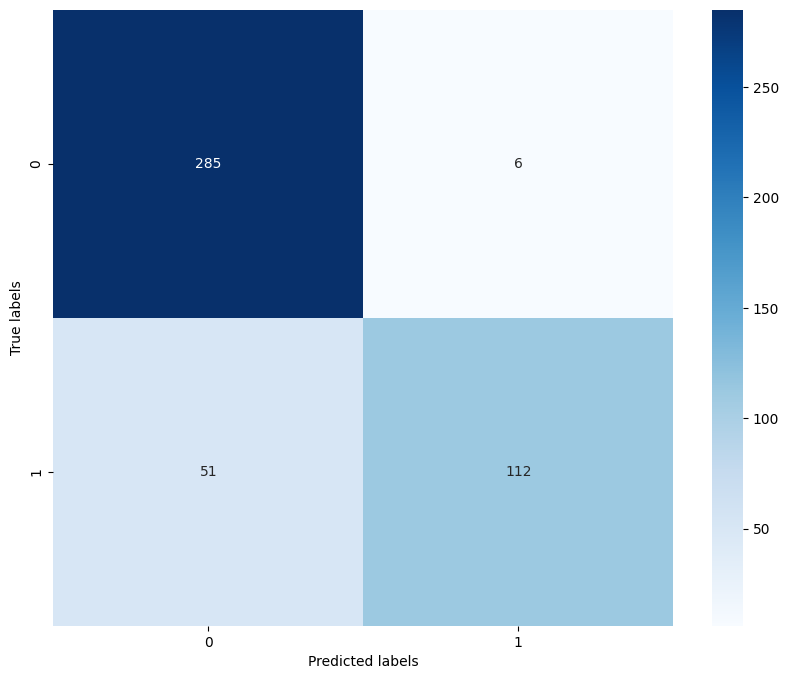

In [ ]:
predictions = model_model1_1.predict(proc_input(X_test), verbose=0)
# Define your labels (0 and 1 in this case)
labels = [0, 1]

# Assuming 'predictions' is an array of probabilities (sigmoid output)
# If 'predictions' contains probabilities, convert them to binary predictions using a threshold of 0.5
binary_predictions = (predictions > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, binary_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


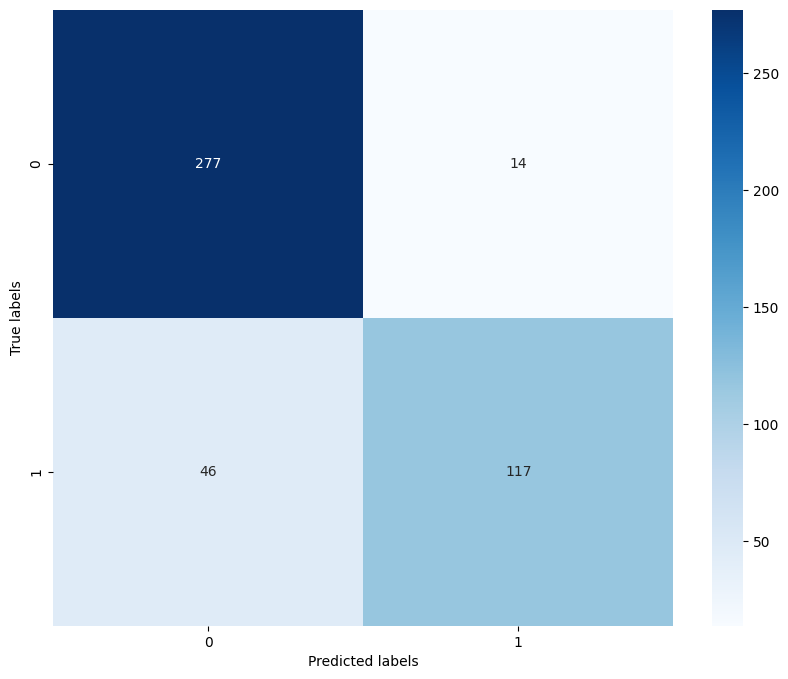

In [ ]:
predictions = model_model2_1.predict(proc_input(X_test), verbose=0)
# Define your labels (0 and 1 in this case)
labels = [0, 1]

# Assuming 'predictions' is an array of probabilities (sigmoid output)
# If 'predictions' contains probabilities, convert them to binary predictions using a threshold of 0.5
binary_predictions = (predictions > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, binary_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


## Manual testing

### Save and convert images to .jpg

In [ ]:
import os
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

# Create a mapping from integer labels to string names
label_names = np.array(["healthy", "unhealthy"])  # Note: Corrected the array definition

# Create folder to store the images in Colab's local disk
root_dir = '/content/test'  # Use the '/content' directory in Colab
os.makedirs(root_dir, exist_ok=True)

# Get the total number of samples in the dataset
n_samples = len(X_test)

# Iterate through the dataset to save images
for i, (image, label) in enumerate(zip(X_test, y_test)):
    # Convert integer label to string name
    label_name = label_names[int(label)]

    # Create class directory if it doesn't exist
    class_dir = os.path.join(root_dir, label_name)
    os.makedirs(class_dir, exist_ok=True)

    # Define image path and save image
    image_path = os.path.join(class_dir, f'image_{i}.jpg')
    img = np.squeeze(image)  # Remove any singleton dimensions
    img = Image.fromarray(image.astype('uint8'))
    img.save(image_path)


### Load them

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    images = np.array(images)
    return images

In [ ]:
healthy_path = '/content/test/healthy/'
unhealthy_path = '/content/test/unhealthy/'

healthy_images = load_images_from_folder(healthy_path)
unhealthy_images = load_images_from_folder(unhealthy_path)

### Plot random healthy and unhealthy images

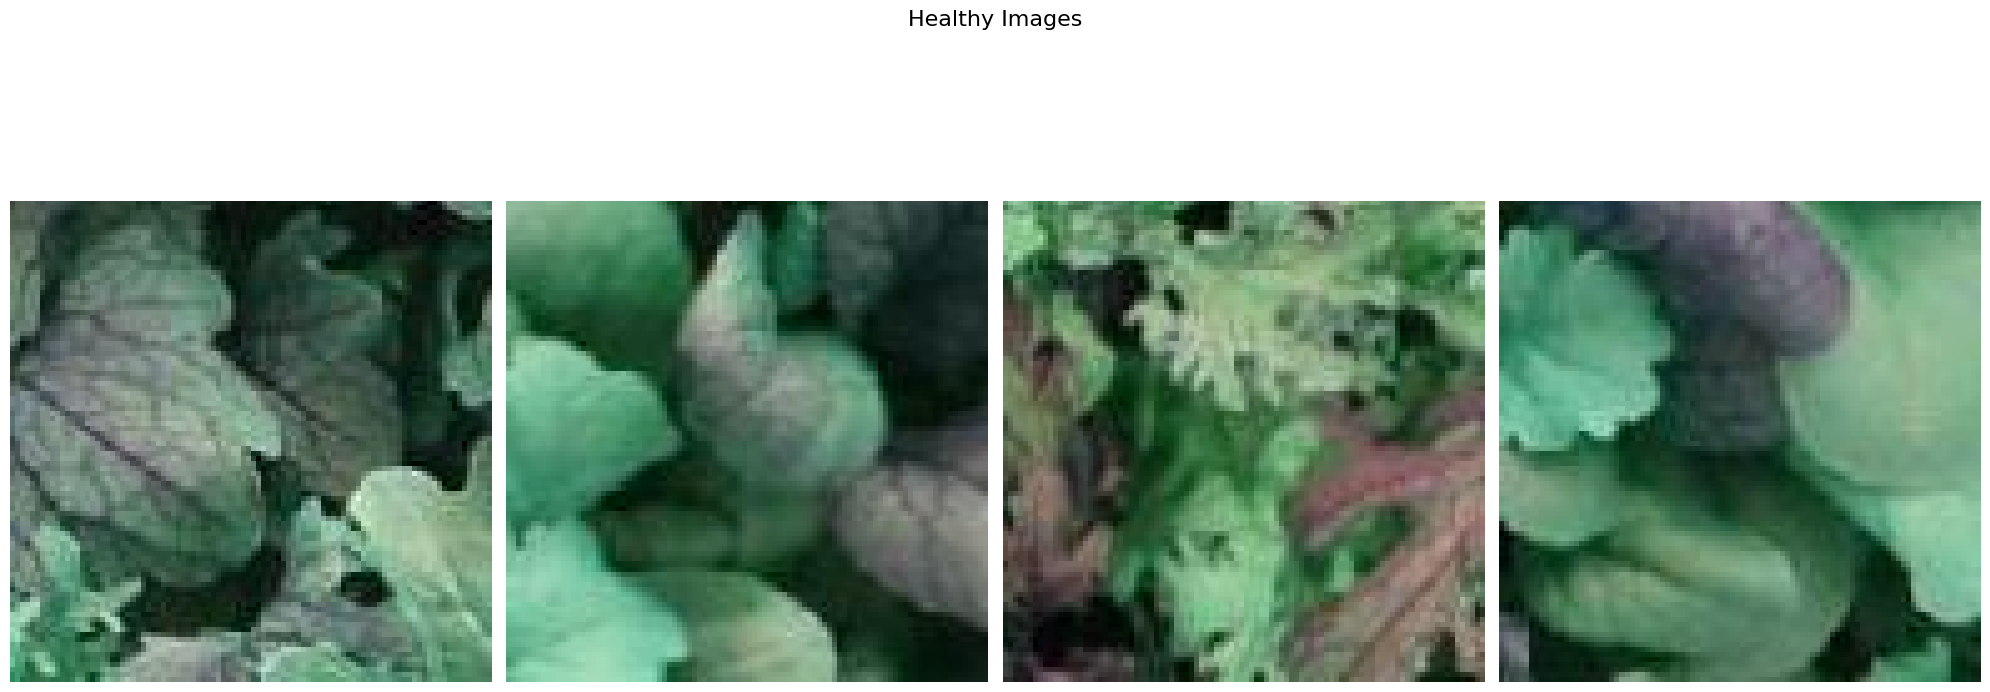

[130 190  72 290]


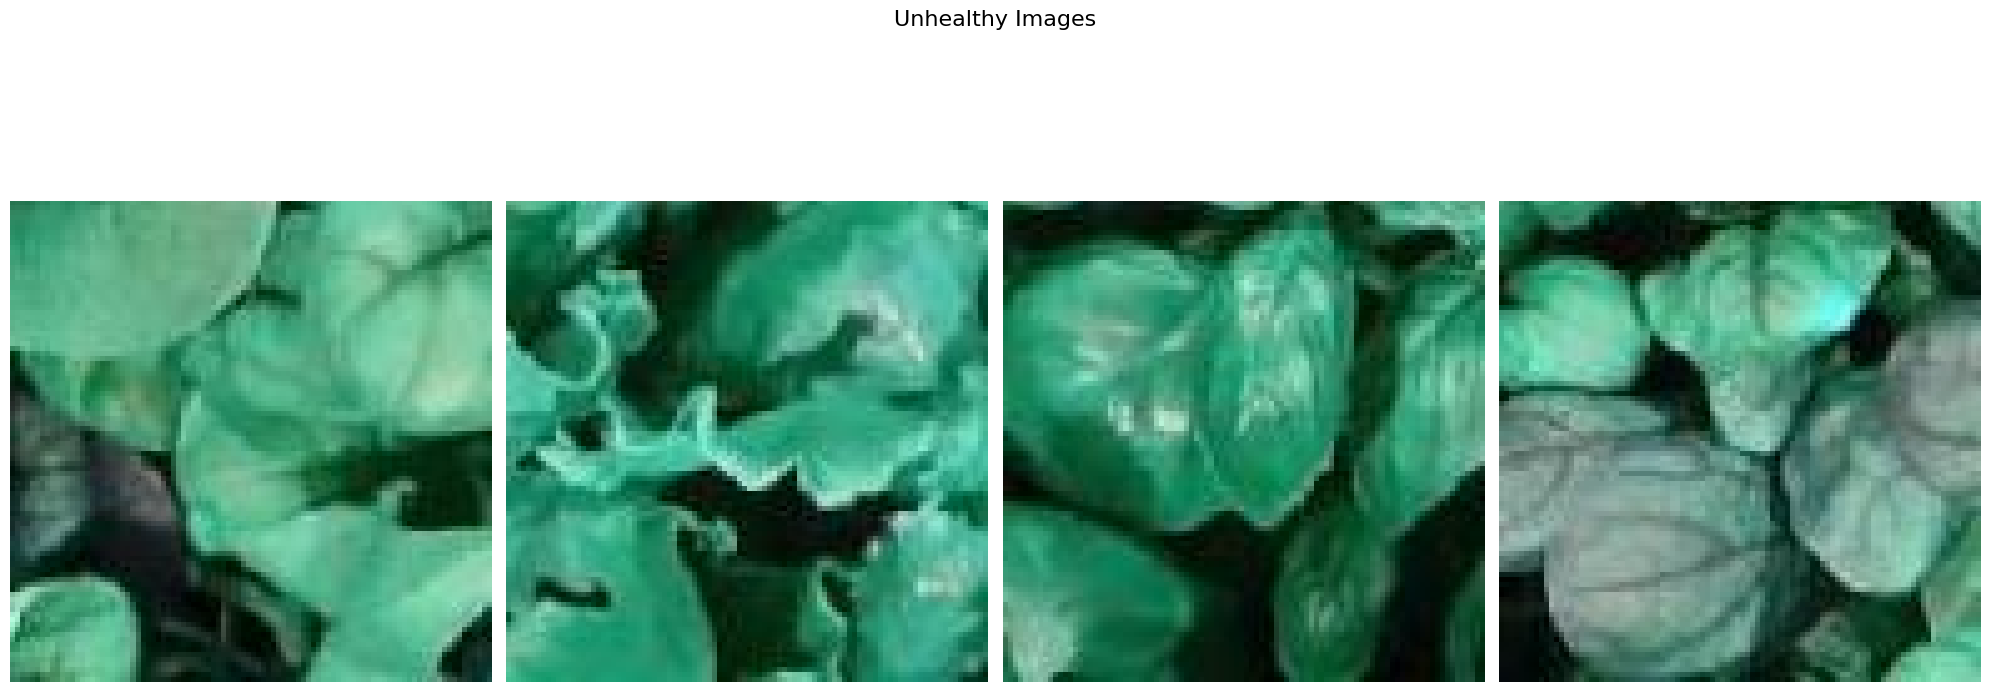

[127  35 142  15]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to display
num_img = 4

# Randomly select indices for healthy and unhealthy images
healthy_indices = np.random.choice(len(healthy_images), num_img, replace=False)
unhealthy_indices = np.random.choice(len(unhealthy_images), num_img, replace=False)

# Create subplots for displaying healthy_images
fig, axes = plt.subplots(1, num_img, figsize=(20, 9))
axes = axes.flatten()
for i in range(num_img):
    ax = axes[i]
    idx = healthy_indices[i]
    ax.imshow(np.clip(healthy_images[idx], 0, 255))  # Display clipped healthy images
    ax.axis("off")
plt.tight_layout()
plt.suptitle("Healthy Images", fontsize=16)  # Use plt.suptitle for the main title
plt.show()
print(healthy_indices)

# Create subplots for displaying unhealthy_images
fig, axes = plt.subplots(1, num_img, figsize=(20, 9))
axes = axes.flatten()
for i in range(num_img):
    ax = axes[i]
    idx = unhealthy_indices[i]
    ax.imshow(
        np.clip(unhealthy_images[idx], 0, 255)
    )  # Display clipped unhealthy images
    ax.axis("off")
plt.tight_layout()
plt.suptitle("Unhealthy Images", fontsize=16)  # Use plt.suptitle for the main title
plt.show()
print(unhealthy_indices)

### Test prediction

In [ ]:
# use indicies from above plot
prediction = model_model1_1.predict(proc_input([healthy_images[119]]), verbose=0)

if prediction >= 0.5:
    label = 'unhealthy'

else:
    label = 'healthy'

print(label)
print(prediction)

unhealthy
[[0.9988776]]


In [ ]:
print(y_test.shape)

(454,)
